# Getting Started with Tensorflow

Tensorflow is a framework for defining and running computational graphs. It's primarily used for deep learning although it can also be used for other numerical computing and machine learning tasks.  

In [1]:
import tensorflow as tf

## Tensorflow Graphs and Sessions

Tensorflow uses computational graphs to run it's functions and models. Graphs are defined by their operations and variables.

Sessions are used to run the a graph. They create the connection between the python program and the C++ TF runtime. Setting up the graph, variables and operations can be done outside the session. But, nothing will be run until it's connected to the session and we evaluate the expression that we created.

In [2]:
# set up two variables
x = tf.Variable(32, name='x')
y = tf.Variable(45, name='y')

# set up some expression to perform on these variables
f = x*y + y*x*y

with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print('Tensorflow Output:', result)
    
print('Python Output:', 32*45 + 45*32*45)

Tensorflow Output: 66240
Python Output: 66240


## Basic Linear Regression in Tensorflow

Running a basic linear regreesion in Tensorflow with built in optimizers and gradient descent algorithms.

In [3]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std

Import the california housing dataset, view the shapes.

In [4]:
housing = fetch_california_housing()

# load the data into numpy arrays
housing_features = housing.data
housing_targets = housing.target

n, f_dim = housing_features.shape

# normalize the features
housing_features= normalize(housing_features)

# add bias
housing_features = np.c_[np.ones((n, 1)), housing_features]

housing_features = housing_features[housing_targets < 5]
housing_targets = housing_targets[housing_targets < 5]

# reshape targets to TF expectation
housing_targets = np.expand_dims(housing_targets, 1)

X_train, X_test, y_train, y_test = train_test_split(housing_features,
                                                    housing_targets,
                                                    test_size=0.1)

print(housing.feature_names)
print(X_train.shape)
print(y_train.shape)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(17683, 9)
(17683, 1)


In [5]:
LR = 0.005
EPOCHS = 5000
# save all of the losses
losses = []

X = tf.placeholder(tf.float32, shape=(None, f_dim+1), name='X')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y')
W = tf.Variable(tf.ones([f_dim+1, 1]))

# after launching a session, run the initializer to initialize all of
# the variables in the graph
init = tf.global_variables_initializer()

# set up operation to get the output from the regression, 
# dot product of weight  and features
y_pred = tf.matmul(X, W)

# calculate the mean squared error
error = y_pred - y
loss = tf.reduce_mean(tf.square(error), name='mse')

# use TF's built in autograd features to run gradient descent
train_step = tf.train.GradientDescentOptimizer(LR).minimize(loss)

In [6]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(EPOCHS):
        if e % 100 == 0:
            print("Epoch:", e, 
                  "Current loss:", 
                  sess.run(loss, feed_dict={X: X_train, y: y_train}), 
                  "Test loss:",
                 sess.run(loss, feed_dict={X: X_test, y: y_test}))
            
        sess.run(train_step, feed_dict={X: X_train, y: y_train})
        losses.append(sess.run(loss, feed_dict={X: X_train, y: y_train}))
        
    best_weights = W.eval()
    save_path = saver.save(sess, '/tmp/linear_regression.ckpt')

Epoch: 0 Current loss: 7.54174 Test loss: 5.1794
Epoch: 100 Current loss: 1.44874 Test loss: 1.33336
Epoch: 200 Current loss: 0.851941 Test loss: 0.867089
Epoch: 300 Current loss: 0.722235 Test loss: 0.743097
Epoch: 400 Current loss: 0.665404 Test loss: 0.686548
Epoch: 500 Current loss: 0.627018 Test loss: 0.649025
Epoch: 600 Current loss: 0.596321 Test loss: 0.619374
Epoch: 700 Current loss: 0.570444 Test loss: 0.594484
Epoch: 800 Current loss: 0.548276 Test loss: 0.573194
Epoch: 900 Current loss: 0.52918 Test loss: 0.554877
Epoch: 1000 Current loss: 0.512691 Test loss: 0.539085
Epoch: 1100 Current loss: 0.498432 Test loss: 0.525456
Epoch: 1200 Current loss: 0.486086 Test loss: 0.513683
Epoch: 1300 Current loss: 0.475381 Test loss: 0.503503
Epoch: 1400 Current loss: 0.466091 Test loss: 0.494693
Epoch: 1500 Current loss: 0.458016 Test loss: 0.487058
Epoch: 1600 Current loss: 0.450987 Test loss: 0.480434
Epoch: 1700 Current loss: 0.444863 Test loss: 0.474679
Epoch: 1800 Current loss: 0.

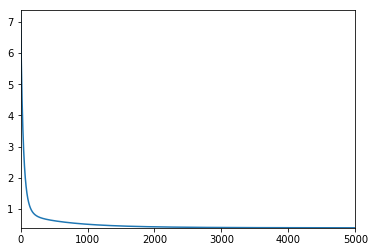

In [7]:
plt.plot(range(len(losses)),np.array(losses))
plt.axis([0,EPOCHS,np.min(losses),np.max(losses)])
plt.show()

### Making predictions on our test data

We will use one of our output functions to generate the predictions for our test set.

In [8]:
# best weight values are saved in the checkpoint
with tf.Session() as sess:
    saver.restore(sess, '/tmp/linear_regression.ckpt')
    preds = sess.run(y_pred, feed_dict={X: X_test})
    print(sess.run(loss, feed_dict={X: X_test, y: y_test}))

INFO:tensorflow:Restoring parameters from /tmp/linear_regression.ckpt
0.433336


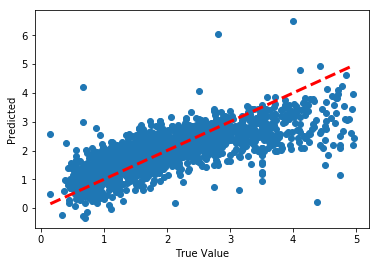

In [9]:
fig, ax = plt.subplots()
ax.scatter(y_test, preds)
ax.plot([y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], '--', lw=3, color='r')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted')
plt.show()